In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Feed-Forward Neural Network with 1 Hidden Layer
## The Model
<img src="pics/ff_nn.png">

In [55]:
D = 2 # number of features/dimensions
K = 3 # number of output classes
M = 3 # number of units in the hidden layer

## The Data
Compared to softmax logistic regression

In [56]:
Nclass = 500 # Number of samples per class
N = K * Nclass

In [57]:
m_cov = [[1, 0],
         [0, 1]]
np.random.seed(41) # make the results reproducible
X = np.concatenate([np.random.multivariate_normal([0,-2], m_cov, Nclass),
                    np.random.multivariate_normal([2,2], m_cov, Nclass),
                   np.random.multivariate_normal([-2,2], m_cov, Nclass)],
                   axis=0)
X.shape

(1500, 2)

The target labels:

In [58]:
T = np.array([0]*Nclass + [1]*Nclass + [2]*Nclass)

In [59]:
df = pd.DataFrame(X, columns=['x', 'y',])
df['class'] = T

In [60]:
# in a separate module to avoid distraction
from lreg_helpers import multivariateGrid

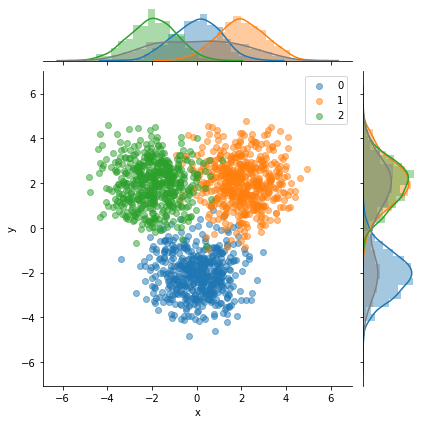

In [61]:
multivariateGrid('x', 'y', 'class', df=df)

The target labels (indicator matrix):

In [62]:
T = np.zeros((K*Nclass, K))
for ki in range(K):
    T[ki*Nclass:(ki+1)*Nclass,ki]=1

In [63]:
pred_T = np.argmax(T, axis=1)
pred_T

## Initialisation

In [65]:
W = np.random.randn(D, M)
b = np.random.randn(M)
V = np.random.randn(M, K)
c = np.random.randn(K)

## The Classification Rate

In [66]:
def classification_rate(Y, P):
    # num correct/num total
    n_total = len(Y)
    n_correct = 0
    for i in range(n_total):
        if Y[i] == P[i]:
            n_correct += 1
    return float(n_correct) / n_total

## Implementation of the Forward-Pass

In [97]:
def forward(X, W, b, V, c):
    Z = 1.0 / (1.0 + np.exp(-X.dot(W) - b))
    A = Z.dot(V) + c
    expA = np.exp(A)
    Y = expA / expA.sum(axis=1, keepdims=True)
    return Y, Z

In [68]:
Y, Z = forward(X, W, b, V, c)

In [69]:
pred_Y = np.argmax(Y, axis=1)

In [70]:
classification_rate(pred_Y, pred_T)

0.3333333333333333

## Parameter Optimisation
Derivation of the gradients with respect to the log-likelihood to avoid carrying around the negative sign: $J=\sum_{n=1}^N\sum_{k=1}^K t_{nk}\log y_{nk}$

$n$ is the index for the sample (row) in $X$

### Gradients with Respect to $V$ and $c$

$$\frac{\partial J}{\partial V_{mk}} = \sum_{n=1}^N \sum_{k'=1}^K \frac{\partial J_{nk'}}{\partial y_{nk'}} \frac{\partial y_{nk'}}{\partial a_{nk}} \frac{\partial a_{nk}}{\partial V_{mk}}$$

$$\frac{\partial J}{\partial c_k} = \sum_{n=1}^N \sum_{k'=1}^K \frac{\partial J_{nk'}}{\partial y_{nk'}} \frac{\partial y_{nk'}}{\partial a_{nk}} \frac{\partial a_{nk}}{\partial c_k}$$

Copying over $\frac{\partial J_{nk'}}{\partial y_{nk'}}$, $\frac{\partial y_{nk'}}{\partial a_{nk}}$, $\frac{\partial J_{nk'}}{\partial y_{nk'}}$ and $\frac{\partial y_{nk'}}{\partial a_{nk}}$ from logistic regression and realising that
$$\frac{\partial a_{nk}}{\partial V_{mk}} = z_{nm}$$
and
$$\frac{\partial a_{nk}}{\partial c_k} = 1$$

leads to 

$$\frac{\partial J}{\partial V_{mk}} = \sum_{n=1}^N (t_{nk}-y_{nk})z_{nm}$$

$$\frac{\partial J}{\partial c_k} = \sum_{n=1}^N (t_{nk}-y_{nk})$$

in vector form:

$$\nabla_VJ=Z^T(T-Y)$$
and the gradient with respect to $c$ directly in code:

```python
grad_c = np.sum(T-Y, axis=0)
```

### Gradients with Respect to $W$ and $b$

$$\frac{\partial J}{\partial W_{dm}} = \sum_{k=1}^N \sum_{n=1}^N \sum_{k'=1}^K \frac{\partial J_{nk'}}{\partial y_{nk'}} \frac{\partial y_{nk'}}{\partial a_{nk}} \frac{\partial a_{nk}}{\partial z_{mk}}\frac{\partial z_{nm}}{\partial \alpha_{nm}} \frac{\partial \alpha_{nm}}{\partial W_{dm}}$$

Copying over $\frac{\partial J_{nk'}}{\partial y_{nk'}}$, $\frac{\partial y_{nk'}}{\partial a_{nk}}$ from logistic regression and realising that
$$\frac{\partial a_{nk}}{\partial z_{mk}} = V_{mk}$$
and 
$$\frac{\partial \alpha_{nm}}{\partial W_{dm}}=x_{nd}$$

$\frac{\partial z_{nm}}{\partial \alpha_{nm}}$ depends on the a choice of the activation function in the hidden layer:

$$\text{for sigmoid} \; \; \rightarrow \; \; \frac{\partial z_{nm}}{\partial \alpha_{nm}}=z_{nm}(1-z_{nm})$$
$$\text{for tanh} \; \; \rightarrow \; \; \frac{\partial z_{nm}}{\partial \alpha_{nm}}=1-z_{nm}^2$$
$$\text{for relu} \; \; \rightarrow \; \; \frac{\partial z_{nm}}{\partial \alpha_{nm}}=step function(z_nm)$$

with sigmoid:
$$\frac{\partial J}{\partial W_{dm}} = \sum_{k=1}^N \sum_{n=1}^N (t_{nk}-y_{nk})V_{mk}(1-z_{nm}) x_{nd}$$

With respect to the bias term:
$$\frac{\partial J}{\partial b_{m}} = \sum_{k=1}^N \sum_{n=1}^N (t_{nk}-y_{nk})V_{mk}(1-z_{nm})$$

Expressing it in Vector Form:
$$\nabla_WJ=X^T \{[(T-Y)V^T] \odot Z \odot (1-Z)\}$$

```python
grad_b = np.sum((T-Y).dot(V.T) * Z * (1-Z), axis=0)
```


### Backpropagation Implementation
Maximise the log-likelihood, i.e. gradient ascent:

In [170]:
np.random.seed(2) # to make it reproducable

In [171]:
W = np.random.randn(D, M)
b = np.random.randn(M)
V = np.random.randn(M, K)
c = np.random.randn(K)

In [172]:
lrate = 0.000001
costs = []

In [173]:
for epoch in range(100000):
    Y, Z = forward(X, W, b, V, c)
     
    if epoch % 100 == 0:
        # The log-likelihood as the cost function to maximise:
        cost = np.sum(T * np.log(Y))
        pred_Y = np.argmax(Y, axis=1)
        r = classification_rate(pred_Y, pred_T)
        # print('cost: {}, classification rate: {}'.format(cost,r))
        costs.append(cost)
        
    # update
    # do all the updates that depend on V before updating V itself
    b += lrate * np.sum((T-Y).dot(V.T) * Z * (1-Z), axis=0)
    W += lrate * X.T.dot( (T - Y).dot(V.T) * Z * (1-Z) )
    
    V += lrate * Z.T.dot(T-Y)
    
    c += lrate * np.sum(T-Y, axis=0)

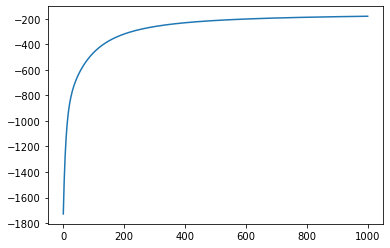

In [174]:
plt.plot(costs)

In [175]:
classification_rate(pred_Y, pred_T)

0.9646666666666667